#### DRIVENData
#### Pale Blue Dot: Visualization Challenge<br>
#### Team: Space Discovery 2024<br>

#### **Dataset obtained from FIRMS Fire Map Los Alerces National Park, Argentina**

https://firms.modaps.eosdis.nasa.gov/download/

#### **Fire Source: 375m data**
  * VIIRS S-NPP
  * VIIRS NOAA-20

#### **Click on Create New Request**
  * Choose a country or in this case a region of Los Alerces National Park, Argentina.<br>
  * And date range<br>
  * Download .CSV

In [1]:
#In case you are running this code in Colab or don't have installed the libraries, run this cell
%pip install geopandas
%pip install pyhdf
%pip install numpy pandas matplotlib cartopy seaborn xarray h5py

# import subprocess
# output = subprocess.check_output('cd', shell=True)
# print(output)

Note: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
    --------------------------------------- 0.0/2.7 MB 653.6 kB/s eta 0:00:05
   -- ------------------------------------- 0.2/2.7 MB 1.3 MB/s eta 0:00:02
   ----- ---------------------------------- 0.4/2.7 MB 2.2 MB/s eta 0:00:02
   -------- ------------------------------- 0.6/2.7 MB 3.0 MB/s eta 0:00:01
   ------------- -------------------------- 0.9/2.7 MB 3.6 MB/s eta 0:00:01
   ----------------- ---------------------- 1.2/2.7 MB 4.1 MB/s eta 0:00:01
   ---------------------- ----------------- 1.5/2.7 MB 4.4 MB/s eta 0:00:01
   ----------------------- ---------------- 1.5/2.7 MB 3.9 MB/s eta 0:00:01
   ----------------------- ---------------- 1.6/2.7 MB 3.6 MB/s eta 0:00:01
   ----------------------------- ---------- 2.0/2.7 MB 4.1 MB/s eta 0:00:01
   ------------------------------

# **Libraries and functions**

#### **Libraries**

In [2]:
# Handling, processing and visualization of data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Handling and processing of georreferenced data
import geopandas as gpd

# Other libraries
# from google.colab import files
import matplotlib.lines as mlines

import datetime as dt
import matplotlib.ticker as plticker

In [3]:
# Libraries for files loading

# Code to read csv file into Colaboratory:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

#### **Functions**

In [4]:
def FileDataDf(dictFiles, i, source):
  ''' This function allows to open csv files stored either in Google Drive or
  from a device. It takes as input a dictionary containing files link or path
  and the index of the element in the dictionary. It also takes a third
  parameter (source) wich specifies the source of the files'''

  if source == 'gdrive': # Files hosted in Google Drive.
    FilesPath = list(dictFiles.values())[i]
    idPath = FilesPath.split('/', 6)
    downloadedFiles = drive.CreateFile({'id':idPath[5]})
    downloadedFiles.GetContentFile(list(dictFiles.keys())[i])
    dfData = pd.read_csv(list(dictFiles.keys())[i])

  elif source == 'other': # Files imported from device or Colab files
    dfData = pd.read_csv(list(dictFiles.values())[i])

  return dfData

def getCoordsSHP(gdfshpFile):
  '''
  This function takes a polygon vector layer file passed as a GeoDataFrame. Then
  it gets all longitude and latitude values and return it as numpy arrays.
  '''

  gdfiterf = gdfshpFile.iterfeatures()
  tupleFile = next(gdfiterf)['geometry']['coordinates']

  arrayCoords = np.array([list(tupleFile[0][i]) for i in range(len(tupleFile[0]))])

  return arrayCoords[:, 0], arrayCoords[:, 1] #xlong, ylat

# **Data loading**

#### **Creating dictionaries containing files path acces.**
##### Write the path/link to load the files as a value of the corresponding key. Be aware of comment/uncomment the correct option whether you are working with multiple files or a single one.

In [5]:
'''Fill the following dictionary with files path or link in case you have data
in separate files for each year.Then, you wil have to merge it.'''


dictFilesPath ={
    "1.csv" : "...", # Year 1
    "2.csv" : "...", # Year 2
    "3.csv" : "...", # Year 3
    "n.csv" : "...", # Year n
    }


'''
Fill the following dictionary with file path or link in case you have data
unified in a single file.
'''

dictFilesPath ={
    # File 2014-2024
    # "1.csv" : "Argentina2019-2024.csv", # Year 1-Year n
    # "1.csv" : "Patagonia2014-2016fire_archive_M-C61_418213.csv", # Year 1-Year n
    # "2.csv" : "Patagonia2016-2024fire_nrt_J1V-C2_418218.csv", # Year 2
    "1.csv" : "MergedPatagonia2014-2024.csv", # Year 1-Year n
    }

#### **Data loading**

In [6]:
FileDataDf(dictFilesPath, 0, source = 'other').head() # Select the correct source

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,-42.489746,-71.451195,343.73,0.56,0.69,2014-01-17,1948,N,VIIRS,n,1,309.34,51.31,D,0
1,-42.489765,-71.451187,337.48,0.56,0.69,2014-01-17,1948,N,VIIRS,n,1,310.16,70.39,D,0
2,-42.493885,-71.441956,345.41,0.56,0.69,2014-01-17,1948,N,VIIRS,n,1,304.72,44.20,D,0
3,-42.487843,-71.445381,367.00,0.56,0.69,2014-01-17,1948,N,VIIRS,h,1,313.03,44.20,D,0
4,-42.487885,-71.445358,367.00,0.56,0.69,2014-01-17,1948,N,VIIRS,h,1,311.23,70.39,D,0


##### Loading of files and merging them into a single Dataframe, if needed.

In [7]:
listColumns = ['latitude', 'longitude', 'acq_date']
dfMerge = pd.DataFrame(columns = listColumns) # Empty Dataframe to merge in case of individual datasets for different years
print(dfMerge)

Empty DataFrame
Columns: [latitude, longitude, acq_date]
Index: []


In [8]:
# Run this cell in case you have different files for each year

for i in range(len(dictFilesPath)):
  dfMerge = pd.concat([dfMerge, FileDataDf(dictFilesPath, i, source = 'other')[listColumns]]) # Select the correct source

dfMerge = dfMerge.reset_index() # To avoid errors, reset indexes in the Dataframe.

C:\Users\Exxolon\AppData\Local\Temp\ipykernel_17640\2221578351.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfMerge = pd.concat([dfMerge, FileDataDf(dictFilesPath, i, source = 'other')[listColumns]]) # Select the correct source


In [9]:
# Run this cell in case you have an unified file for study period analysis

dfMerge = FileDataDf(dictFilesPath, 0, source = 'other')[listColumns] # Select the correct source

In [10]:
dfMerge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   6956 non-null   float64
 1   longitude  6956 non-null   float64
 2   acq_date   6956 non-null   object 
dtypes: float64(2), object(1)
memory usage: 163.2+ KB


In [11]:
# Start
dfMerge.head(5)

,latitude,longitude,acq_date
0,-42.489746,-71.451195,2014-01-17
1,-42.489765,-71.451187,2014-01-17
2,-42.493885,-71.441956,2014-01-17
3,-42.487843,-71.445381,2014-01-17
4,-42.487885,-71.445358,2014-01-17


In [12]:
# End
dfMerge.tail(5)

,latitude,longitude,acq_date
6951,-43.189938,-71.808250,2021-11-03
6952,-42.985893,-72.144836,2021-11-09
6953,-42.452785,-71.438019,2022-02-09
6954,-42.895206,-71.576591,2022-02-15
6955,-42.376068,-72.413162,2022-03-15


##### Final version of merged Dataframe

In [13]:
#dfMerge

# **Data processing**

##### Dropping "index" column from final merged Dataframe NOT RUN

In [14]:
# It's not necessary if you don't merge files.
# DONT RUN
# dfMerge = dfMerge.drop('index', axis = 1)

##### Making a copy of Dataframe with a more accurate name.

NOTE: When changing the year and month filter you must run copy() again.

In [15]:
dfHSArg = dfMerge.copy()

##### Creation of extra columns based on year and month from adquisition date.

In [16]:
dfHSArg['year_acq'] = [dfHSArg['acq_date'][i][0:4] for i in range(len(list(dfHSArg['acq_date'])))]
dfHSArg['month_acq'] = [dfHSArg['acq_date'][i][5:7] for i in range(len(list(dfHSArg['acq_date'])))]
# print(dfHSArg['year_acq'])
# print(dfHSArg['month_acq'])

##### Filtering data by year_acq value for the period 2014-2024
##### By changing the variable **yearConsul** and **monthConsul** we can filter the hot spots by year and month on the map.

In [17]:
# Per year
# By changing this value, the hot spots for each year can be displayed.
yearConsul = '2015'
dfHSArg = dfHSArg[dfHSArg['year_acq'] == yearConsul ]

# Per month.
monthConsul = '01'
# Breaking down the line below we can see the information filtered by month.
# dfHSArg = dfHSArg[dfHSArg['month_acq'] == monthConsul ]


#### Filtering data by type column.

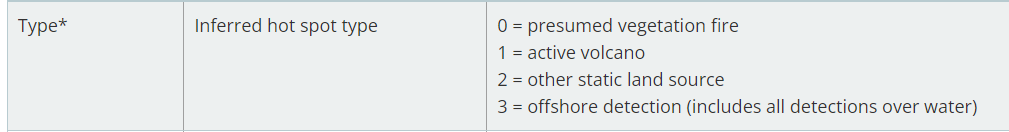

Source: https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/vnp14imgtdlnrt

In [18]:
# NO RUN
# dfHSArg = dfHSArg[dfHSArg['type'] == 0]

#### Review of Dataframe after first processing (optional)

In [19]:
dfHSArg

,latitude,longitude,acq_date,year_acq,month_acq
38,-42.915459,-71.294846,2015-01-10,2015,01
39,-42.516758,-71.421288,2015-01-23,2015,01
40,-42.268250,-71.711365,2015-01-30,2015,01
41,-42.264927,-71.704315,2015-01-30,2015,01
42,-42.266411,-71.704475,2015-01-30,2015,01
...,...,...,...,...,...
6063,-43.229595,-72.338943,2015-12-02,2015,12
6064,-43.234081,-72.337234,2015-12-02,2015,12
6065,-43.094387,-72.450706,2015-12-04,2015,12
6066,-42.926086,-71.311043,2015-12-18,2015,12


# **Data visualization and selection of study area points**

##### Creating a GeoDataframe from original Pandas Dataframe

This is the second sample of information, the previous one is data, this one is visual.<br>
You have to download .shape files

In [20]:
# Convertion of pandas dataframe into a geopandas dataframe with geometry set as points from latitude and longitude
gdfHSArg = gpd.GeoDataFrame(
    dfHSArg,
    geometry=gpd.points_from_xy(dfHSArg['longitude'], dfHSArg['latitude']),
    crs='epsg:4326')

##### Loading Argentina and study area vector layers

To download shape Argentina green color link:<br>
https://www.ign.gob.ar/NuestrasActividades/InformacionGeoespacial/CapasSIG


In [21]:
# Reading vector layers
Country = gpd.read_file('.\\ArgIGN\\pais.shp')
StudyArea = gpd.read_file('.\\ParqueLosAlerces\\ParqueAlerces.shp')

#### **Visualization of processed data in the map**

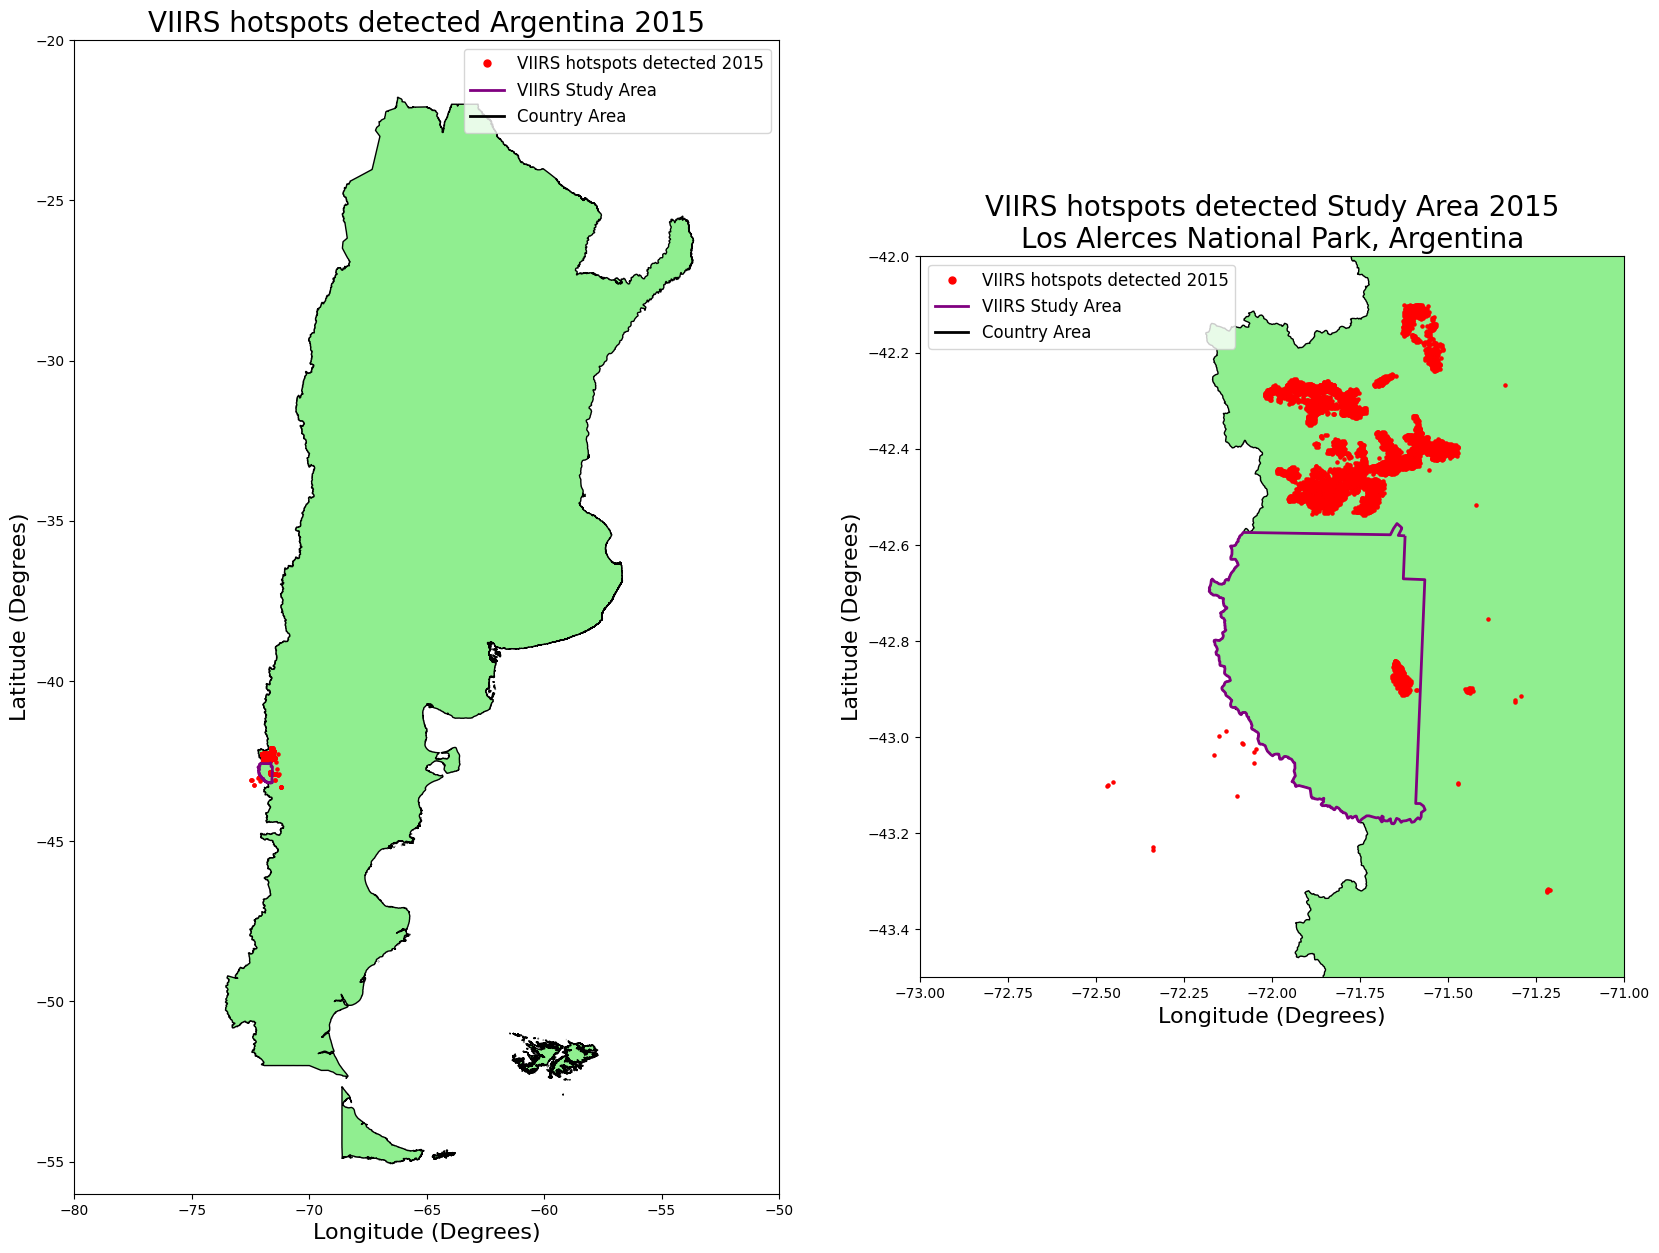

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

# First subplot
Country.plot( ax = axs[0], facecolor= 'lightgreen', edgecolor='black')
gdfHSArg.plot(ax = axs[0], markersize = 5, color = 'red', alpha = 1)
StudyArea.plot(ax = axs[0], facecolor = 'none', edgecolor = 'purple', linewidth = 2)

legStudyArea = mlines.Line2D([], [], color = 'purple', marker= 'None', linestyle = '-', linewidth = 2)
legHSArg = mlines.Line2D([], [], color = 'red', marker = 'o', markersize = 5, linestyle='None')
legCountryArea = mlines.Line2D([], [], color = 'black', marker= 'None', linestyle = '-', linewidth = 2)
axs[0].legend(handles=[legHSArg, legStudyArea, legCountryArea],
              labels=['VIIRS hotspots detected ' + yearConsul, 'VIIRS Study Area', 'Country Area'],
              fontsize = 12,
              loc='best')

axs[0].set_ylim(-56, -20)
axs[0].set_xlim(-80, -50)
axs[0].set_title('VIIRS hotspots detected Argentina ' + yearConsul, fontsize = 20)
axs[0].set_xlabel('Longitude (Degrees)', fontsize = 16)
axs[0].set_ylabel('Latitude (Degrees)', fontsize = 16)

# Second subplot
Country.plot( ax = axs[1], facecolor= 'lightgreen', edgecolor='black')
gdfHSArg.plot(ax = axs[1], markersize = 5, color = 'red', alpha = 1)
StudyArea.plot(ax = axs[1], facecolor = 'none', edgecolor = 'purple', linewidth = 2)

axs[1].legend(handles=[legHSArg, legStudyArea, legCountryArea],
              labels=['VIIRS hotspots detected ' + yearConsul, 'VIIRS Study Area', 'Country Area'],
              fontsize = 12,
              loc='best')

xlong, ylat = getCoordsSHP(Country)
# axs[1].set_xlim([xlong.min() - 0.2, xlong.max() + 0.2])
# axs[1].set_ylim([ylat.min() - 0.2, ylat.max() + 0.2])
axs[1].set_ylim(-43.5, -42)
axs[1].set_xlim(-73, -71)

# axs[1].set_ylim(-56, -20)
# axs[1].set_xlim(-80, -50)

axs[1].set_title('VIIRS hotspots detected Study Area ' + yearConsul + '\nLos Alerces National Park, Argentina', fontsize = 20)
axs[1].set_xlabel('Longitude (Degrees)', fontsize = 16)
axs[1].set_ylabel('Latitude (Degrees)', fontsize = 16)

plt.savefig('HSArgentina-StudyArea.png') # Uncomment if you want to download the image

plt.show()

##### Run the following code to download the image with the visualization of heatspots

#### **Extraction of data by study area**

##### Visualization of filtered data by study area in the map. Image generated with Worldview Snapshots:
[Link](https://wvs.earthdata.nasa.gov/?LAYERS=MODIS_Terra_CorrectedReflectance_TrueColor&CRS=EPSG:4326&TIME=2023-12-08&COORDINATES=-60.000000,-80.000000,-35.000000,-50.000000&FORMAT=image/jpeg&AUTOSCALE=TRUE&RESOLUTION=1km)

In [23]:
# Use of within() method to filter original GeoDataframe
filtergdfHSArg = gdfHSArg[gdfHSArg.geometry.within(StudyArea.geometry.iloc[0])]

In [24]:
filtergdfHSArg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 209 entries, 5286 to 6044
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   latitude   209 non-null    float64 
 1   longitude  209 non-null    float64 
 2   acq_date   209 non-null    object  
 3   year_acq   209 non-null    object  
 4   month_acq  209 non-null    object  
 5   geometry   209 non-null    geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 11.4+ KB


##### Visualization of filtered data by study area in the map

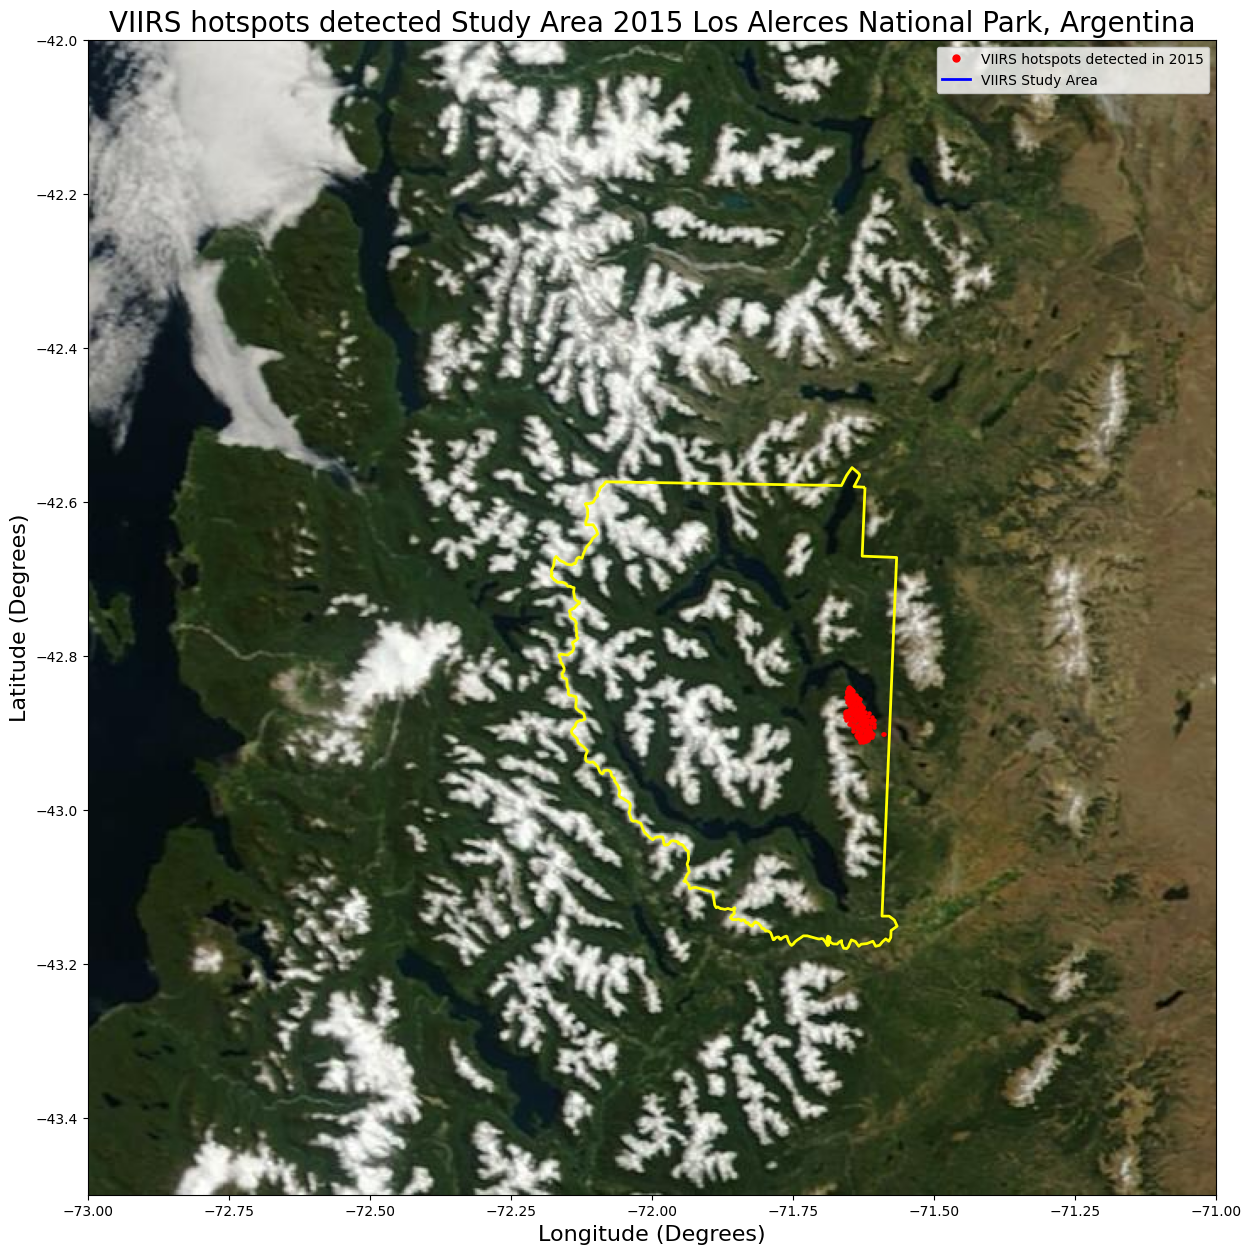

In [25]:
fig, axs = plt.subplots(figsize=(15, 15))

imgBkg = plt.imread(".\\backgroundImageArgentina.jpg")

# Country
# Country.plot( ax = axs, facecolor= 'none', edgecolor='blue')
# Background
# axs.imshow(imgBkg, extent=[-80, -40, -50, -35])
axs.imshow(imgBkg, extent=[-73, -71, -43.5, -42])
# Hotspots
# filtergdfHSArg = Filtered points
# gdfHSArg = All points
filtergdfHSArg.plot(ax = axs, markersize = 5, color = 'red', alpha = 1)

StudyArea.plot(ax = axs, facecolor = 'none', edgecolor = 'yellow', linewidth = 2)

legStudyArea = mlines.Line2D([], [], color = 'blue', marker= 'None', linestyle = '-', linewidth = 2)
legHSArg = mlines.Line2D([], [], color = 'red', marker = 'o', markersize = 5, linestyle='None')

axs.legend(handles=[legHSArg, legStudyArea], labels=['VIIRS hotspots detected in ' + yearConsul, 'VIIRS Study Area'], loc='best')


# xlong, ylat = getCoordsSHP(Country)
# axs[1].set_xlim([xlong.min() - 0.2, xlong.max() + 0.2])
# axs[1].set_ylim([ylat.min() - 0.2, ylat.max() + 0.2])
axs.set_ylim(-43.5, -42)
axs.set_xlim(-73, -71)
axs.set_title('VIIRS hotspots detected Study Area ' + yearConsul + ' Los Alerces National Park, Argentina', fontsize = 20)
axs.set_xlabel('Longitude (Degrees)', fontsize = 16)
axs.set_ylabel('Latitude (Degrees)', fontsize = 16)

plt.savefig('HSStudyArea.png') # Uncomment if you want to download the image

plt.show()

# **Data visualization and analysis of fire occurrence phenomena**


##### Run the following code to generate the image with the graph of the total number of hot spots detected per year

In [26]:
# Dataframe with total daily detected hotspots
dfHSArgPatagoniaCount = dfMerge['acq_date'].value_counts().to_frame()

# Format correction of new Dataframe with total daily hotspots
acq_dates = dfHSArgPatagoniaCount.index
dfHSArgPatagoniaCount.rename(columns = {'acq_date':'total_hs'}, inplace = True)
dfHSArgPatagoniaCount['acq_date'] = acq_dates
dfHSArgPatagoniaCount.reset_index(drop=True, inplace=True)

# Change of acq_date column values from string to datetime data type
dfHSArgPatagoniaCount['acq_date'] = pd.to_datetime(dfHSArgPatagoniaCount['acq_date'], format='%Y-%m-%d')

# Creation of extra columns based on year and month from adquisition date as string data type
dfHSArgPatagoniaCount['year_acq'] = [str(dfHSArgPatagoniaCount['acq_date'][i])[0:4] for i in range(len(list(dfHSArgPatagoniaCount['acq_date'])))]
dfHSArgPatagoniaCount['month_acq'] = [str(dfHSArgPatagoniaCount['acq_date'][i])[5:7] for i in range(len(list(dfHSArgPatagoniaCount['acq_date'])))]

In [27]:
dfHSArgPatagoniaCount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   count      195 non-null    int64         
 1   acq_date   195 non-null    datetime64[ns]
 2   year_acq   195 non-null    object        
 3   month_acq  195 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 6.2+ KB


In [28]:
dfHSArgPatagoniaCount.head(5)

,count,acq_date,year_acq,month_acq
0,701,2015-02-23,2015,02
1,609,2015-02-25,2015,02
2,507,2015-02-18,2015,02
3,504,2015-02-21,2015,02
4,372,2015-02-26,2015,02


In [29]:
# Dataframe with total daily detected hotspots
dfHSArgPatagoniaCount = dfMerge['acq_date'].value_counts().to_frame()

# Format correction of new Dataframe with total daily hotspots
acq_dates = dfHSArgPatagoniaCount.index
dfHSArgPatagoniaCount.rename(columns = {'acq_date':'total_hs'}, inplace = True)
dfHSArgPatagoniaCount['acq_date'] = acq_dates
dfHSArgPatagoniaCount.reset_index(drop=True, inplace=True)

# Change of acq_date column values from string to datetime data type
dfHSArgPatagoniaCount['acq_date'] = pd.to_datetime(dfHSArgPatagoniaCount['acq_date'], format='%Y-%m-%d')

# Creation of extra columns based on year and month from adquisition date as string data type
dfHSArgPatagoniaCount['year_acq'] = [str(dfHSArgPatagoniaCount['acq_date'][i])[0:4] for i in range(len(list(dfHSArgPatagoniaCount['acq_date'])))]
dfHSArgPatagoniaCount['month_acq'] = [str(dfHSArgPatagoniaCount['acq_date'][i])[5:7] for i in range(len(list(dfHSArgPatagoniaCount['acq_date'])))]
print(dfHSArgPatagoniaCount)

     count   acq_date year_acq month_acq
0      701 2015-02-23     2015        02
1      609 2015-02-25     2015        02
2      507 2015-02-18     2015        02
3      504 2015-02-21     2015        02
4      372 2015-02-26     2015        02
..     ...        ...      ...       ...
190      1 2018-03-04     2018        03
191      1 2017-09-26     2017        09
192      1 2017-09-18     2017        09
193      1 2017-05-26     2017        05
194      1 2022-03-15     2022        03

[195 rows x 4 columns]


In [30]:
dfHSArgPatagoniaCount.head(5)

,count,acq_date,year_acq,month_acq
0,701,2015-02-23,2015,02
1,609,2015-02-25,2015,02
2,507,2015-02-18,2015,02
3,504,2015-02-21,2015,02
4,372,2015-02-26,2015,02


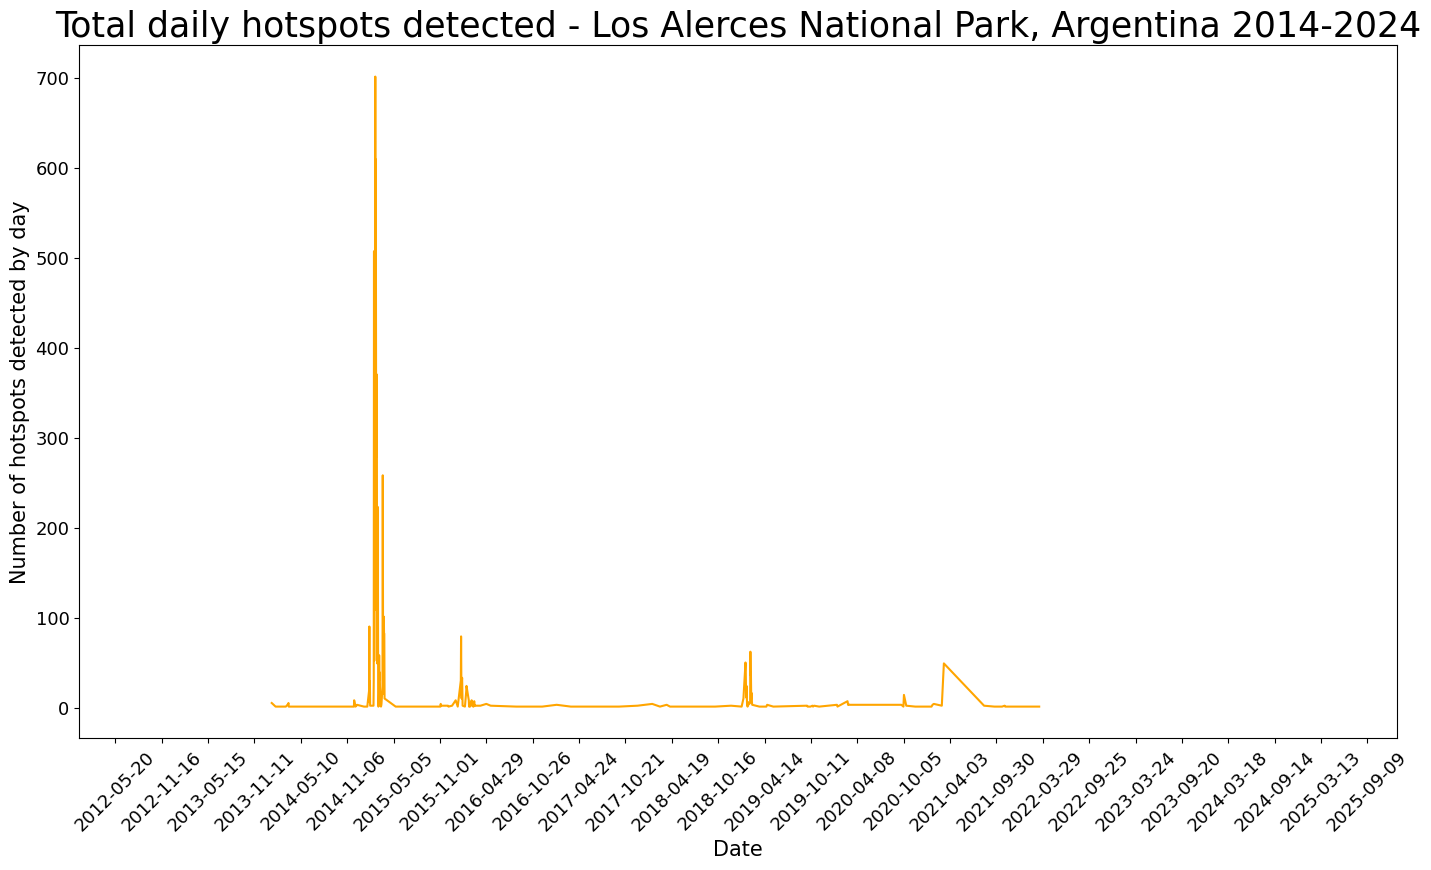

In [31]:
# Plot
dfHSArgPatagoniaCountPlot = dfHSArgPatagoniaCount.copy().sort_values(by='acq_date', ascending= True) # Run this line to avoid incompatibilities when plotting

fig, ax = plt.subplots(figsize=(17, 9))

ax.plot(dfHSArgPatagoniaCountPlot['acq_date'],
        dfHSArgPatagoniaCountPlot['count'],
        linestyle = "-", color = "orange",
        label = "Total daily hotspots")

ax.set_ylabel("Number of hotspots detected by day", fontsize = 15)
ax.set_xlabel("Date", fontsize = 15)
ax.set_title("Total daily hotspots detected - Los Alerces National Park, Argentina 2014-2024", fontsize = 25)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlim([dt.date(2012,1,1), dt.date(2026,1,1)])

loc = plticker.MultipleLocator(base= (30*6)) # This locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.setp(ax.get_xticklabels(), rotation = 45)

plt.savefig('Dailyhotspots2012-2021.png') # Uncomment if you want to download the image

plt.show()

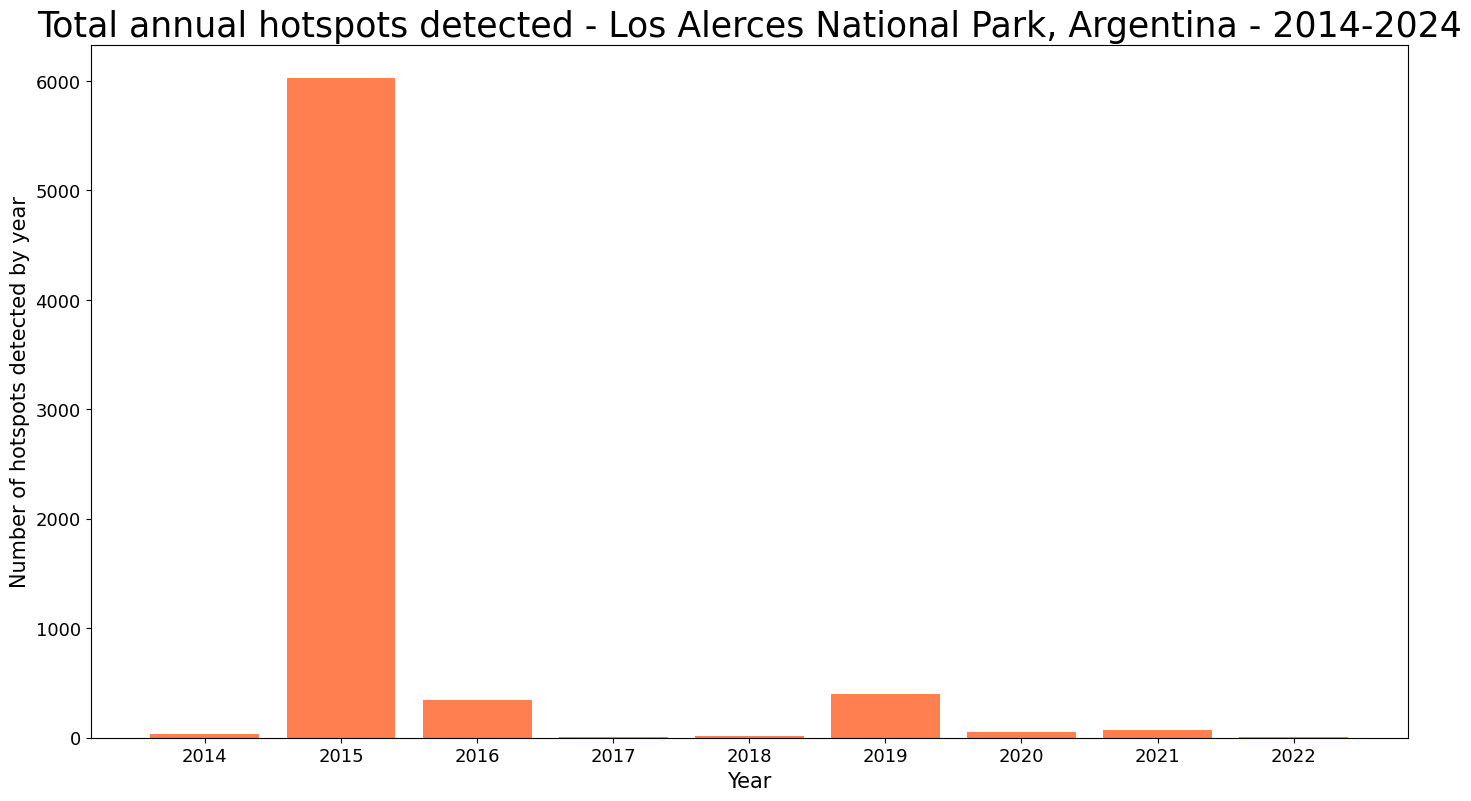

In [32]:
dataTotalhsYear = dfHSArgPatagoniaCount.groupby('year_acq')['count'].sum() # Dataframe with total detected hotsposts by year

fig, ax= plt.subplots(figsize=(17, 9))

ax.bar(dataTotalhsYear.index.tolist(),
        np.array(dataTotalhsYear.values),
        color='coral')

ax.set_ylabel("Number of hotspots detected by year", fontsize = 15)
ax.set_xlabel("Year", fontsize = 15)
ax.set_title("Total annual hotspots detected - Los Alerces National Park, Argentina - 2014-2024", fontsize = 25)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)

plt.savefig('Annualhotspots2014-2024.png') # Uncomment if you want to download the image

plt.show()

In [33]:
dataTotalhsYear.sort_values(ascending = False)

year_acq
2015    6030
2019     398
2016     344
2021      67
2020      48
2014      38
2018      17
2017      11
2022       3
Name: count, dtype: int64

##### NOTE: All generated images are saved in the current folder.

With the information displayed graphically, statistical projections can be made or AI predictive models can be trained.

DRIVENData<br>
Pale Blue Dot: Visualization Challenge<br>
Team: Space Discovery 2024<br>


![alt](MITLicenseLogo.jpg)<br>
MIT License

Copyright ©️2024 Walter M. Wagner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
